In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

def step1(file):
    
    gray = cv2.cvtColor(file, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)
    
    rows = gray.shape[0]
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, rows / 8,
                               param1 = 100, param2 = 30,
                               minRadius = 1, maxRadius = 30)
    circles = np.uint16(np.around(circles))

    src = cv2.cvtColor(file, cv2.COLOR_BGR2RGB)

    info = [[i[2]] for i in circles[0]] 

    coords_aux = [[i[0], i[1]] for i in circles[0]]
    scls_aux = [src[i[1]][i[0]].tolist() for i in coords_aux] 
                    
    for n in range(len(info)):
        for t in coords_aux[n]:
            info[n].append(t)
        for i in scls_aux[n]:
            info[n].append(i)
            
    return info, scls_aux

def step2(scls_aux):
    
    X = pd.DataFrame(scls_aux)
    distortions = []
    K = range(1,10)
    for k in K:
        kmns = KMeans(n_clusters = k, random_state = 123)
        kmns.fit(X)
        distortions.append(kmns.inertia_)
    plt.figure(figsize = (6, 4))   
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.show()
    
def step3(scls_aux, optimal_k):
    X = pd.DataFrame(scls_aux)

    kmns = KMeans(n_clusters = optimal_k, random_state = 123)
    kmns.fit(X)
    fig = plt.figure(figsize = (6, 4))
    ax = Axes3D(fig, rect = [0, 0, .95, 1], elev = 48, azim = 134)
    labels = kmns.labels_
    ax.scatter(X[0], X[1], X[2], c = labels.astype(np.float), edgecolor = 'k')
    plt.show()
    
def step4(scls_aux, info, optimal_k):
    
    X = pd.DataFrame(scls_aux)
    kmns = KMeans(n_clusters = optimal_k, random_state = 123)
    kmns.fit(X)
    clusters = kmns.predict(scls_aux).tolist()

    for n in range(len(info)):
        info[n].append(clusters[n])
    df = pd.DataFrame(info, columns = ['radius', 'x', 'y','r', 'g', 'b', 'cluster'])
    
    return df

def step5(df):
    
    df_color_tuples = df.groupby('cluster').median()[['r', 'g', 'b']]
    df_color_tuples = df_color_tuples.apply(lambda x: round(x)).astype(int)
    return df_color_tuples

def label_clusters(x, labels):
    for n in labels:
        if x == n:
            return labels[n]
        
def step6(df, labels):
    df['cluster_label'] = df['cluster'].apply(lambda x: label_clusters(x, labels))
    df.drop(columns = ['r', 'g', 'b', 'cluster'], inplace = True)
    return df

def step7(df, src):
    
    txt = 0
    for n in range(len(df)):
        center = (df['x'].iloc[n], df['y'].iloc[n])
        cv2.circle(src, center, 1, (0, 100, 100), 3)
        radius = df['radius'].iloc[n]
        cv2.circle(src, center, radius, (255, 0, 255), 3)
        cv2.putText(src, str(txt), center, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3)
        txt += 1
    plt.imshow(src)
    plt.show()

    df.drop(columns = ['x', 'y'], inplace = True)
    df['radius'] = df['radius'].apply(lambda x: np.pi*(x**2))
    df = df.rename(columns = {'radius':'area'})

    df['dev'] = df['area'] - df['area'].mean()
    df['zscore'] = df['dev'] / df['area'].std()
    df.drop(columns = ['dev'], inplace = True)
    df[['area', 'zscore']] = df[['area', 'zscore']].apply(lambda x: round(x, 2))
    print(df[['cluster_label', 'area', 'zscore']])
    
    return df

def step8(df):
    print('--------------------------')
    print('ESTATÍSTICAS GERAIS')
    print('')
    print(df['area'].agg(['mean', 'std', 'count']))
    print('--------------------------')
    print('ESTATÍSTICAS POR COR')
    df_final = df.groupby('cluster_label').agg({'area':['mean', 'std', 'count']})
    df_final['prop'] = df_final['area']['count'] / df_final['area']['count'].sum()
    print(df_final)

def first(file, n_colors):
    info, scls_aux = step1(file)
    step2(scls_aux)
    step3(scls_aux, n_colors)
    return info, scls_aux

def second(scls_aux, info, n_colors):
    df = step4(scls_aux, info, n_colors)
    df_colors = step5(df)
    return df, df_colors

def third(file, labels_dict, df):
    df = step6(df, labels_dict)
    df = step7(df, file)
    df_final = step8(df)

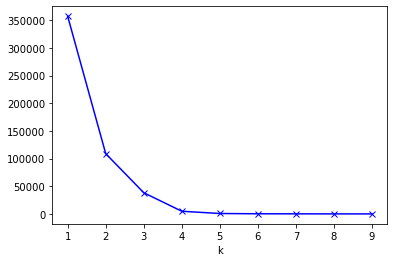

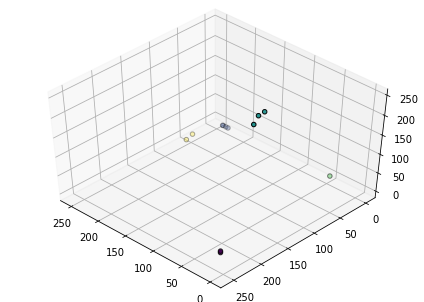

In [2]:
info, scls_aux = first(cv2.imread('smarties.png'), 5)

In [3]:
df, df_colors = second(scls_aux, info, 5)
df_colors

,r,g,b
cluster,,,
0,0,255,50
1,236,0,0
2,62,124,247
3,43,3,11
4,250,53,0


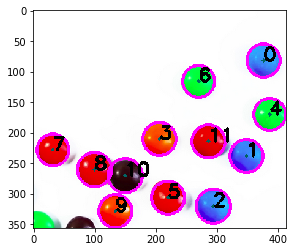

    cluster_label     area  zscore
0            azul  2290.22   -0.01
1            azul  2290.22   -0.01
2            azul  2463.01    1.37
3         laranja  2290.22   -0.01
4           verde  2123.72   -1.34
5        vermelho  2290.22   -0.01
6           verde  2123.72   -1.34
7        vermelho  2123.72   -1.34
8        vermelho  2463.01    1.37
9         laranja  2290.22   -0.01
10  marrom_escuro  2463.01    1.37
11       vermelho  2290.22   -0.01
--------------------------
ESTATÍSTICAS GERAIS

mean     2291.792500
std       125.301901
count      12.000000
Name: area, dtype: float64
--------------------------
ESTATÍSTICAS POR COR
                      area                        prop
                      mean         std count          
cluster_label                                         
azul           2347.816667   99.760353     3  0.250000
laranja        2290.220000    0.000000     2  0.166667
marrom_escuro  2463.010000         NaN     1  0.083333
verde          2123.720000   

In [4]:
third(cv2.cvtColor(cv2.imread('smarties.png'), cv2.COLOR_BGR2RGB), 
      {0 : 'verde', 1 : 'vermelho', 2 : 'azul', 3 : 'marrom_escuro', 4 : 'laranja'}, 
      df)